In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import re
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier

import seaborn as sns
%matplotlib inline

In [2]:
final = pd.read_csv("final.csv", 
                             names = ['case' ,'platform', 'customer_id', 'timeStamp',
                                      'matched_payment_complete', 'label', 'name', 'email', 'gender', 'age',
                                      'home_type', 'square_footage', 'number_of_bedrooms', 'number_of_floors',
                                      'household', 'platform_y', 'street', 'suburb'])

final['times_denid']=final.groupby('customer_id')['label'].cumsum()
final.columns

Index(['case', 'platform', 'customer_id', 'timeStamp',
       'matched_payment_complete', 'label', 'name', 'email', 'gender', 'age',
       'home_type', 'square_footage', 'number_of_bedrooms', 'number_of_floors',
       'household', 'platform_y', 'street', 'suburb', 'times_denid'],
      dtype='object')

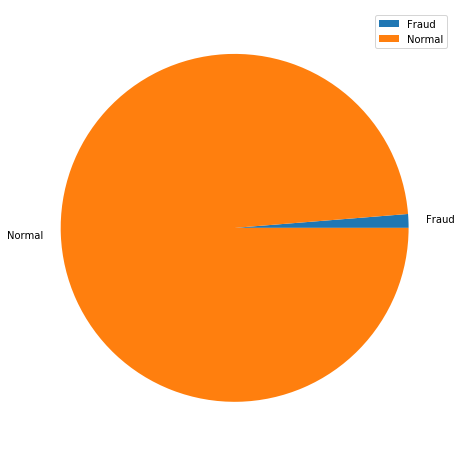

<Figure size 432x288 with 0 Axes>

In [3]:
# plot a pie chart displaying the proportion of fraudulent claims
df = pd.DataFrame([final.label.sum(),final.label.shape[0]-final.label.sum()], index=['Fraud', 'Normal'], columns=[""])
df.plot(kind='pie', subplots=True, figsize=(8, 8))
fig = plt.gcf()
plt.show()
plt.draw()
fig.savefig('fraud_vs_normal.png', dpi=100)

In [4]:
by_suburb = final[['suburb','label']].groupby("suburb").agg(['sum','count'])
by_suburb['fraud_ratio'] = by_suburb["label","sum"] / by_suburb["label","count"]
by_suburb = by_suburb.sort_values(by ='fraud_ratio' ,ascending = False)
by_suburb.head(5)

label       fraud_ratio
                    sum count            
suburb                                   
Banks Points         29   136    0.213235
Rebecca Island       27   138    0.195652
Larry View           27   148    0.182432
Connie Terrace       19   107    0.177570
Bolton Point Apt.    20   119    0.168067

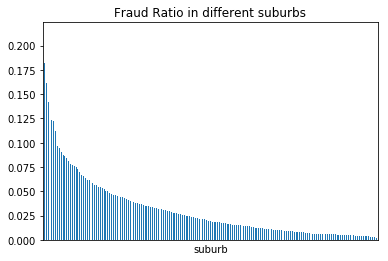

<Figure size 432x288 with 0 Axes>

In [5]:
by_suburb.fraud_ratio.plot.bar(title="Fraud Ratio in different suburbs")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
fig = plt.gcf()
plt.show()
plt.draw()
fig.savefig('suburb.png', dpi=100,bbox_inches='tight')

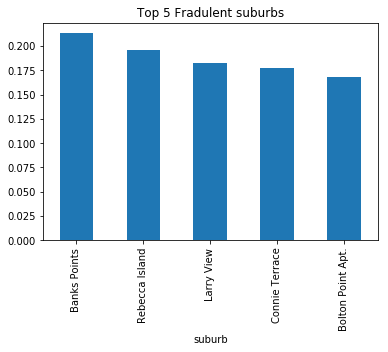

<Figure size 432x288 with 0 Axes>

In [6]:

by_suburb[['fraud_ratio']].head().plot.bar(title="Top 5 Fradulent suburbs",legend=False)
fig = plt.gcf()
plt.show()
plt.draw()
fig.savefig('top_suburb.png', dpi=100,bbox_inches='tight')

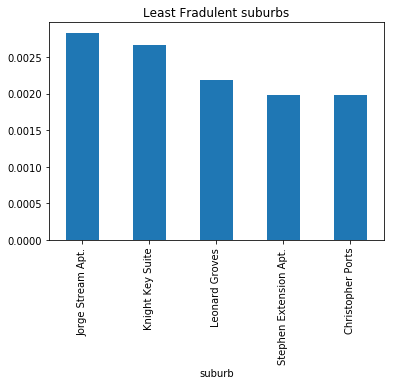

<Figure size 432x288 with 0 Axes>

In [7]:
by_suburb[['fraud_ratio']].tail().plot.bar(title="Least Fradulent suburbs",legend=False)
fig = plt.gcf()
plt.show()
plt.draw()
fig.savefig('tail_suburb.png', dpi=100,bbox_inches='tight')

In [8]:
final.groupby("label").mean()

,timeStamp,matched_payment_complete,age,home_type,square_footage,number_of_bedrooms,number_of_floors,times_denid
label,,,,,,,,
0,1.520734e+09,0.002315,43.525834,0.677537,302.042401,2.447706,1.000001,0.000391
1,1.514369e+09,1.000000,45.317419,0.640747,293.598808,2.347341,1.000000,1.000286


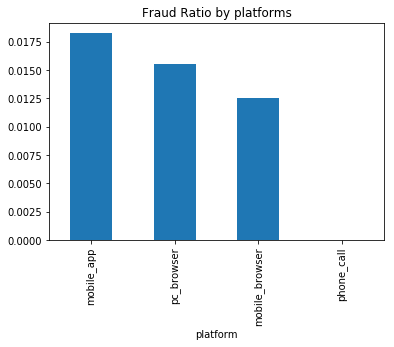

<Figure size 432x288 with 0 Axes>

In [9]:
# then we invistigate different platforms 
by_platform = final[['platform','label']].groupby("platform").agg(['sum','count'])
by_platform['fraud_ratio'] = by_platform["label","sum"] / by_platform["label","count"]
by_platform = by_platform.sort_values(by ='fraud_ratio' ,ascending = False)
by_platform.fraud_ratio.plot.bar(title= "Fraud Ratio by platforms")
# as we can see, claims coming from mobile apps are more
# end up being frauds, while phone calls are never fradulent 
fig = plt.gcf()
plt.show()
plt.draw()
fig.savefig('by_platform.png', dpi=300,bbox_inches='tight')

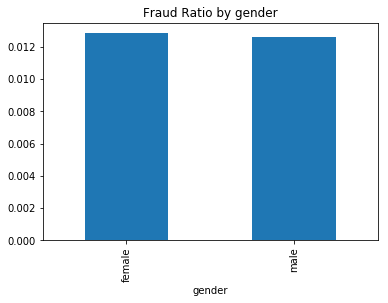

<Figure size 432x288 with 0 Axes>

In [10]:
# we can look at gender distribution as well
by_gender = final[['gender','label']].groupby("gender").agg(['sum','count'])
by_gender['fraud_ratio'] = by_gender["label","sum"] / by_gender["label","count"]
by_gender = by_gender.sort_values(by ='fraud_ratio' ,ascending = False)
by_gender.fraud_ratio.plot.bar(title= "Fraud Ratio by gender")
# as we can see, claims coming from mobile apps are more
# end up being frauds, while phone calls are never fradulent 
fig = plt.gcf()
plt.show()
plt.draw()
fig.savefig('by_gender.png', dpi=300,bbox_inches='tight')
# there isn't distinct difference when it comes to gender 
# we can conduct statistical test to validate these results

In [11]:
X = final.drop("label", axis =1 )
Y = final.label

X.gender = X.gender.map({"male":1,"female":0})
le = preprocessing.LabelEncoder()
le.fit(X.suburb.unique().tolist()) # taking all the suburbs 
X.suburb = le.transform(X.suburb)
le_plat = preprocessing.LabelEncoder()
le_plat.fit(X.platform.unique().tolist()) 
X.platform = le_plat.transform(X.platform)
X=X[['matched_payment_complete','suburb','times_denid']]

X.head()

,matched_payment_complete,suburb,times_denid
0,1,325,1
1,1,189,0
2,1,453,1
3,1,297,1
4,1,288,1


In [12]:
mid = int(X.shape[0]*0.8)
X_train = X[:mid]
Y_train = Y[:mid]

X_test = X[mid:]
Y_test = Y[mid:]

# simple decision tree
clf = DecisionTreeClassifier(random_state=2 )

clf.fit(X_train, Y_train)

pred_label = pd.Series(clf.predict(X_test))
y_test = pd.Series(Y_test.tolist())

# True Negative rate on test:  TN / N
TN = ((y_test == pred_label)&(y_test==0) ).sum()
TP = ((y_test == pred_label)&(y_test==1) ).sum()

TNR = TN / (len(Y_test)- Y_test.sum())
TPR = TP/ Y_test.sum()

FP = ((y_test != pred_label)&(y_test==0) ).sum()
print("False Positives: {:.5f} normal people misclassified as frauds".format(FP))

print("True Negative rate on test: {:.6f}".format(TNR))
# print("True Positives: {:.5f}".format(TP))
print("True Positive rate on test: {:.6f}".format(TPR))

False Positives: 0.00000 normal people misclassified as frauds
True Negative rate on test: 1.000000
True Positive rate on test: 1.000000


In [13]:
clf.feature_importances_

array([0.02420439, 0.        , 0.97579561])

In [18]:
import graphviz


In [14]:
a= len(final[(final.matched_payment_complete==1)&(final.times_denid>0)&(final.label==1)]) 
b= len(final[(final.times_denid>0)&(final.matched_payment_complete==1)])
a/b

1.0